In [1]:
# Necessary imports\n",
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Get the COVID dataset
filename1 = os.path.join(os.getcwd(), "weekly_covid_county_level_US.csv")
df1 = pd.read_csv(filename1, header=0)

# Get the weather dataset
filename2 = os.path.join(os.getcwd(), "weekly_tavg_county_cont_US.csv")
df2 = pd.read_csv(filename2, header=0)

In [3]:
# Rename county_name to county in weekly_covid_county_level_US.csv
df1.rename(columns={'county_name': 'County'}, inplace=True)
df1.rename(columns={'report_date': 'Week'}, inplace=True)
df1.rename(columns={'state_name': 'State'}, inplace=True)

# Sort df1 by County to match with df2
sorted_df1 = df1.sort_values(by=['State','County', 'Week'])
#display(sorted_df1)

# Sort df2 by County to match with df1
sorted_df2 = df2.sort_values(by=['State','County', 'Week'])
    
#Drop 10/06 and 10/13 and 05/28/23 - 06/06/24 to match with when COVID data ends from df2 
values_todrop = ['2022-10-06', '2022-10-13', '2023-05-18', '2023-05-25', '2023-06-01', '2023-06-08', '2023-06-15', '2023-06-22', '2023-06-29', '2023-07-06',
'2023-07-13', '2023-07-20', '2023-07-27', '2023-08-03', '2023-08-10', '2023-08-17', '2023-08-24', '2023-08-31', '2023-09-07', '2023-09-14', '2023-09-21',
'2023-09-28', '2023-10-05', '2023-10-12', '2023-10-19', '2023-10-26', '2023-11-02', '2023-11-09', '2023-11-16', '2023-11-23', '2023-11-30', '2023-12-07',
'2023-12-14', '2023-12-21', '2023-12-28', '2024-01-04', '2024-01-11', '2024-01-18', '2024-01-25', '2024-02-01', '2024-02-08', '2024-02-15', '2024-02-22',
'2024-02-29', '2024-03-07', '2024-03-14', '2024-03-21', '2024-03-28', '2024-04-04', '2024-04-11', '2024-04-18', '2024-04-25', '2024-05-02', '2024-05-09',
'2024-05-16', '2024-05-23', '2024-05-30', '2024-06-06']

sorted_df2 = sorted_df2[~sorted_df2['Week'].isin(values_todrop)]

#dictionary of state names to map to state abbr
state_abbrev_to_name = {'AL': 'Alabama','AK': 'Alaska','AZ': 'Arizona','AR': 'Arkansas','CA': 'California','CO': 'Colorado','CT': 'Connecticut','DE': 'Delaware',
'FL': 'Florida','GA': 'Georgia','HI': 'Hawaii','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','IA': 'Iowa','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana',
'ME': 'Maine','MD': 'Maryland','MA': 'Massachusetts','MI': 'Michigan','MN': 'Minnesota','MS': 'Mississippi','MO': 'Missouri','MT': 'Montana','NE': 'Nebraska',
'NV': 'Nevada','NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NY': 'New York','NC': 'North Carolina','ND': 'North Dakota','OH': 'Ohio','OK': 'Oklahoma',
'OR': 'Oregon','PA': 'Pennsylvania','RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VT': 'Vermont',
'VA': 'Virginia','WA': 'Washington','WV': 'West Virginia','WI': 'Wisconsin','WY': 'Wyoming','DC': 'District of Columbia','PR': 'Puerto Rico'}

sorted_df2['State'] = sorted_df2['State'].map(state_abbrev_to_name)
#output both sorted dataframes into csv files
sorted_df1.to_csv('sortedcovid.csv', index=False)
sorted_df2.to_csv('sortedweather.csv', index=False)

In [4]:
# Merge the two datasets into a new dataset on the county column
# The new df is sorted by the County column
df = pd.merge(sorted_df1, sorted_df2, on=['State', 'County', 'Week'], how='inner')
   
# Drop FIPS, fips_code and state_abbr columns since they are unnecessary and repeating
df = df.drop(columns=['FIPS', 'fips_code', 'state_abbr'])

#print(df.head(130))
display(df)

,State,County,Week,cases_per_100K_7_day_count_change,percent_test_results_reported_positive_last_7_days,community_transmission_level,Temperature
0,Alabama,Autauga,2022-10-20,53.70,10.22,substantial,14.82
1,Alabama,Autauga,2022-10-27,50.12,6.63,substantial,14.58
2,Alabama,Autauga,2022-11-03,55.49,NaN,substantial,16.88
3,Alabama,Autauga,2022-11-10,107.39,3.74,high,19.69
4,Alabama,Autauga,2022-11-17,37.59,6.62,moderate,10.04
...,...,...,...,...,...,...,...
93235,Wyoming,Weston,2023-04-13,14.44,NaN,moderate,7.42
93236,Wyoming,Weston,2023-04-20,14.44,NaN,moderate,6.71
93237,Wyoming,Weston,2023-04-27,0.00,NaN,low,3.49
93238,Wyoming,Weston,2023-05-04,0.00,NaN,low,10.42


In [5]:
#rename Temperature column to Avg Temp
df.rename(columns={'Temperature': 'Avg Temp'}, inplace=True)

#reorder dataframe columns
order = ['State', 'County', 'Week', 'cases_per_100K_7_day_count_change','percent_test_results_reported_positive_last_7_days','community_transmission_level', 'Avg Temp']
df = df[order]

#make Temp Flux column/feature
df['Temp Flux'] = df.groupby('County')['Avg Temp'].diff()

#double check null values
print(df.isnull().sum())

#dropped percent_test_results_reported_positive_last_7_days and community_transmission_level
#because the columns have high null values and are not related to our ML problem
df = df.drop(columns=['percent_test_results_reported_positive_last_7_days', 'community_transmission_level'])\

#handle NaN values for the first date 2022-10-20
#This occurs because temp flux = curr week - prev week, and the first week(2022-10-20) doesn't have a previous week
#solution: Only NaN values are for 2022-10-20, so we are using the county's temp flux for 2022-10-27 to replace the NaN
temp_flux_nulls = (df['Week'] == '2022-10-20') & (df['Temp Flux'].isna())
df.loc[temp_flux_nulls, 'Temp Flux'] = df.groupby('County')['Temp Flux'].shift(-1)

print(df.isnull().sum())

df.to_csv('final_dataset.csv', index=False)
#display(df)

State                                                     0
County                                                    0
Week                                                      0
cases_per_100K_7_day_count_change                         0
percent_test_results_reported_positive_last_7_days    20450
community_transmission_level                            495
Avg Temp                                                  0
Temp Flux                                              1840
dtype: int64
State                                0
County                               0
Week                                 0
cases_per_100K_7_day_count_change    0
Avg Temp                             0
Temp Flux                            0
dtype: int64


C:\Users\umafeb\AppData\Local\Temp\ipykernel_12444\3127733032.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


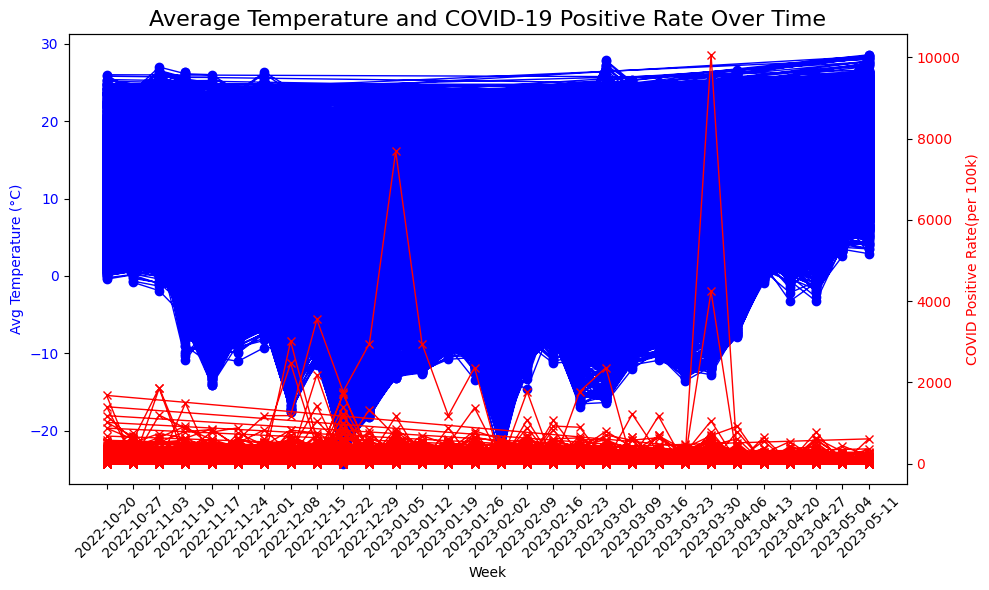

In [6]:
#AVG TEMP & COVID ~ TIME SERIES PLOT
fig, ax1 = plt.subplots(figsize=(10, 6))

# plot average temperature on left y-axis
ax1.set_xlabel('Week')
ax1.set_ylabel('Avg Temperature (°C)', color='blue')
ax1.plot(df['Week'], df['Avg Temp'], color='blue', marker='o', linewidth=1)
ax1.tick_params(axis='y', labelcolor='blue')

# plot positive rate of covid on right side y-axis
ax2 = ax1.twinx()  # instantiate a second y-axis sharing the same x-axis
ax2.set_ylabel('COVID Positive Rate(per 100k)', color='red')
ax2.plot(df['Week'], df['cases_per_100K_7_day_count_change'], color='red', marker='x', linewidth=1)
ax2.tick_params(axis='y', labelcolor='red')

# make x-axis visible by rotating x-axis ticks
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# title and layout(makes sure it fits nice) 
plt.title('Average Temperature and COVID-19 Positive Rate Over Time', fontsize=16)
fig.tight_layout()

# display the plot
plt.show()


C:\Users\umafeb\AppData\Local\Temp\ipykernel_12444\461148173.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)


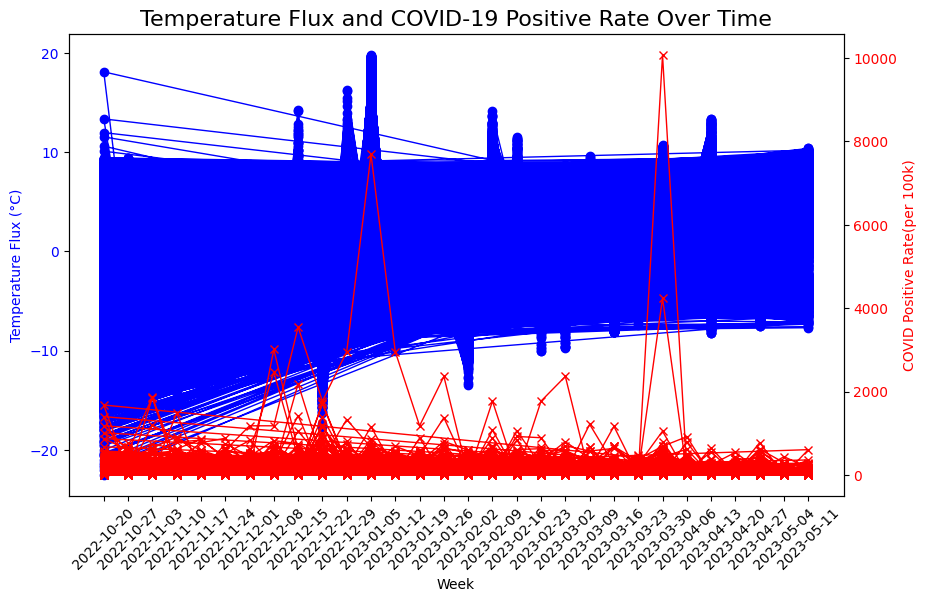

In [7]:
#TEMP FLUX & COVID ~ TIME SERIES PLOT
fig1, ax3 = plt.subplots(figsize=(10, 6))

# plot temperature flux on left y-axis
ax3.set_xlabel('Week')
ax3.set_ylabel('Temperature Flux (°C)', color='blue')
ax3.plot(df['Week'], df['Temp Flux'], color='blue', marker='o', linewidth=1)
ax3.tick_params(axis='y', labelcolor='blue')

# plot positive rate of covid right side y-axis
ax2 = ax3.twinx()  # instantiate a second y-axis sharing the same x-axis
ax2.set_ylabel('COVID Positive Rate(per 100k)', color='red')
ax2.plot(df['Week'], df['cases_per_100K_7_day_count_change'], color='red', marker='x', linewidth=1)
ax2.tick_params(axis='y', labelcolor='red')

# make x-axis visible by rotating x-axis ticks
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)

# title and layout(makes sure it fits nice) 
plt.title('Temperature Flux and COVID-19 Positive Rate Over Time', fontsize=16)
fig.tight_layout()

# display the plot
plt.show()